In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import re
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [30]:
city = "San Francisco"
num = 410
split_point = 10 # do not use lot of test data, or else it will come a constant
split_point_train = 400
data = pd.DataFrame([])

humidity = pd.read_csv("time-series-datasets/historical-hourly-weather-data/humidity.csv")
data['humidity'] = humidity[city][:num]
data["datetime"] = humidity["datetime"][:num]
pressure = pd.read_csv("time-series-datasets/historical-hourly-weather-data/pressure.csv")
data['pressure'] = pressure[city][:num]
temperature = pd.read_csv("time-series-datasets/historical-hourly-weather-data/temperature.csv")
data['temperature'] = temperature[city][:num]
wind_speed = pd.read_csv("time-series-datasets/historical-hourly-weather-data/wind_speed.csv")
data['wind_speed'] = wind_speed[city][:num]

In [31]:
print(data.shape)
data = data.dropna(how = "any")
print(data.shape)

(410, 5)
(409, 5)


In [32]:
data.describe()

humidity     pressure  temperature  wind_speed
count  409.000000   409.000000   409.000000  409.000000
mean    71.088020  1015.789731   290.311974    3.095355
std     16.532857     4.515745     4.269038    2.466084
min     11.000000  1000.000000   283.050000    0.000000
25%     63.000000  1013.000000   287.080000    1.000000
50%     72.000000  1016.000000   289.370000    3.000000
75%     82.000000  1019.000000   293.020000    5.000000
max    100.000000  1026.000000   304.860000   12.000000

In [33]:
date = pd.to_datetime(data.datetime, format = "%Y-%m-%d %H:%M")
data.index = date
data = data.drop(["datetime"], axis = 1)
data.head()

humidity  pressure  temperature  wind_speed
datetime                                                        
2012-10-01 13:00:00      88.0    1009.0   289.480000         2.0
2012-10-01 14:00:00      87.0    1009.0   289.474993         2.0
2012-10-01 15:00:00      86.0    1009.0   289.460618         2.0
2012-10-01 16:00:00      85.0    1009.0   289.446243         2.0
2012-10-01 17:00:00      84.0    1009.0   289.431869         2.0

In [34]:
test = data[split_point_train:]
train = data[:split_point_train]

In [35]:
train.shape, test.shape

((400, 4), (9, 4))

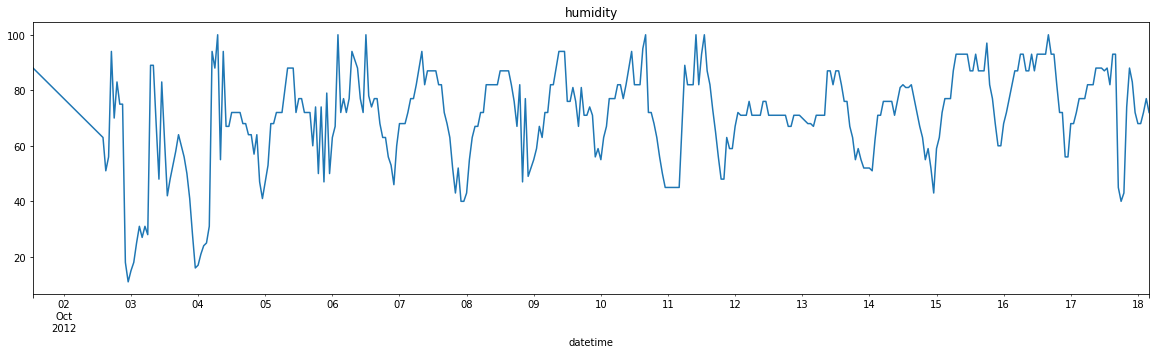

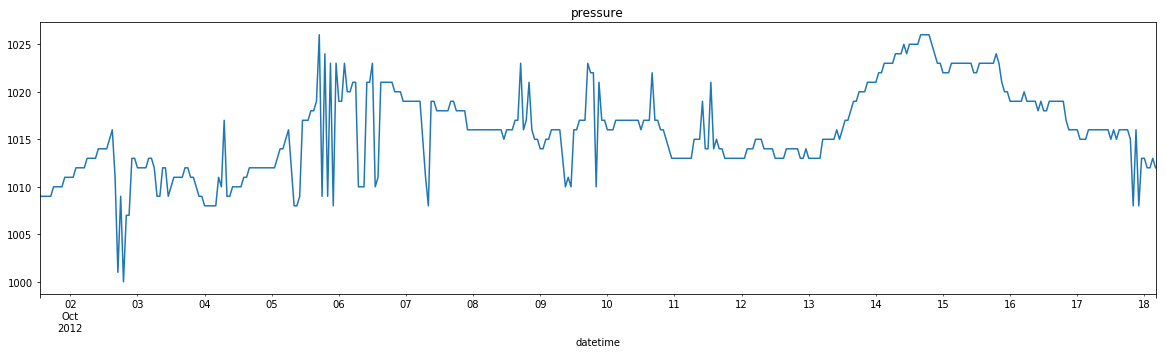

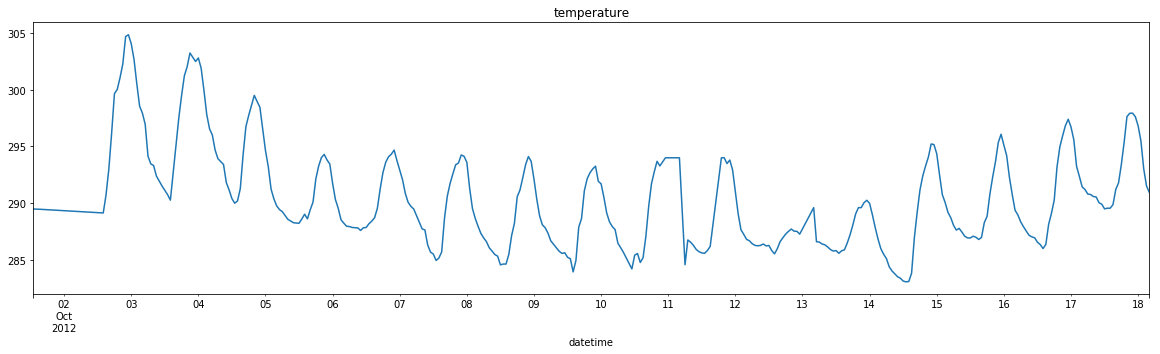

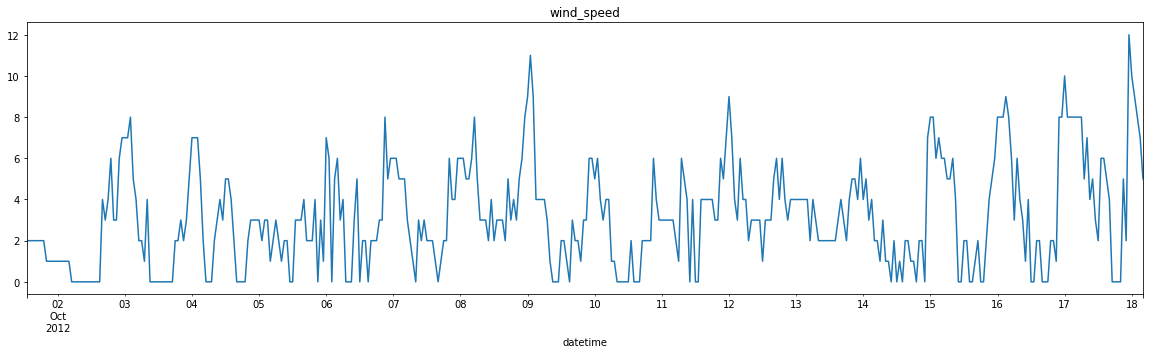

In [36]:
data = data.astype(float)

for cl in data.columns:
    if cl == "description":
        plt.figure(figsize = (20,5))
        descr = train.groupby(["description"]).count()["humidity"]
        good = descr[descr >= 2000]
        bed = descr[descr < 2000]
        good["other"] = sum(bed)
        plt.bar(good.index, good)
        continue
    plt.figure(figsize = (20,5))
    #plt.scatter(data.index, data[cl])
    train[cl].plot(title = cl)
    plt.show()

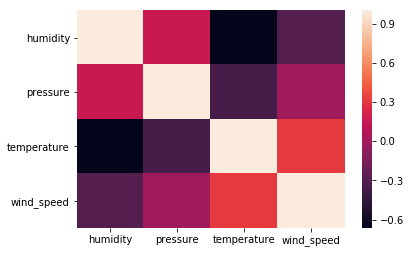

In [38]:
import seaborn as sns
corr_data = data.corr()
sns.heatmap(corr_data)

# Check the stationarity

For this we have to find **eigenvalues** of matrix Ф. To learn more how do we find the matrix Ф here: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

The idea is to conduct **Johansen’s test**, that will give us the eigenvalues. 

1) eigenvalues < 1 => **stationary**

2) eigenvalues > 1 => non-stationary


In [39]:
coint_johansen(data,-1,1).eig 

array([1.43717725e-01, 1.14815629e-01, 7.96832209e-02, 1.08180163e-05])

## Apply VAR model

In [46]:
model = VAR(endog = data)
model_fit = model.fit(maxlags = 14) ### maxlags - the order of VAR process == p 

C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [47]:
preds_var = model_fit.forecast(train.values.tolist(), steps = len(test)) ### steps - how much data forward you want to predict 

preds_var = preds_var.transpose()

for i, cl in enumerate(data.columns):
    print('mse value for ', cl, ' is : ', mean_squared_error(preds_var[i], test[cl]))
    print('rmse value for ', cl, ' is : ', np.sqrt(mean_squared_error(preds_var[i], test[cl])))
    print('mae value for ', cl, ' is : ', mean_absolute_error(preds_var[i], test[cl]))

mse value for  humidity  is :  18.584022948723014
rmse value for  humidity  is :  4.3109190375977855
mae value for  humidity  is :  3.311426678487188
mse value for  pressure  is :  1.0523652758096083
rmse value for  pressure  is :  1.0258485637800583
mae value for  pressure  is :  0.9188356033512642
mse value for  temperature  is :  3.560791189401359
rmse value for  temperature  is :  1.8870058795354505
mae value for  temperature  is :  1.7407065275101559
mse value for  wind_speed  is :  2.226097931950585
rmse value for  wind_speed  is :  1.49201137125378
mae value for  wind_speed  is :  1.3568541072462068


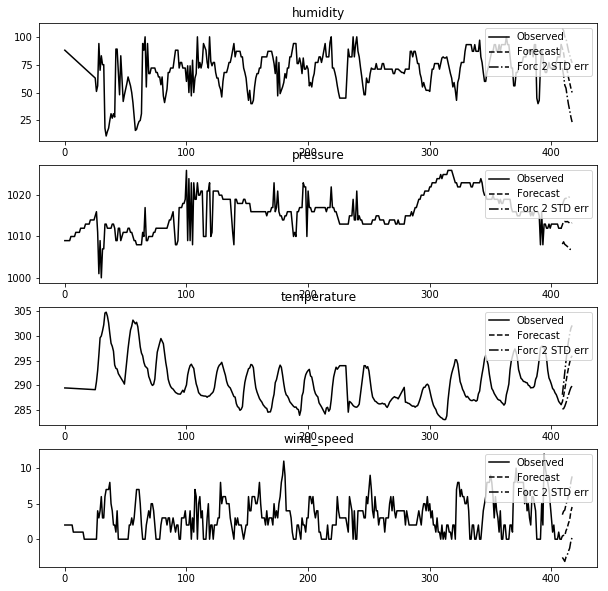

In [48]:
model_fit.plot_forecast(len(test))
plt.show()

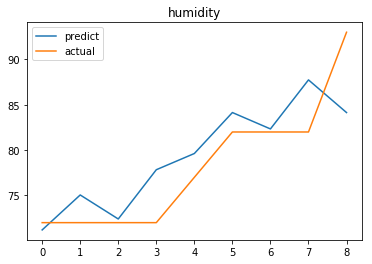

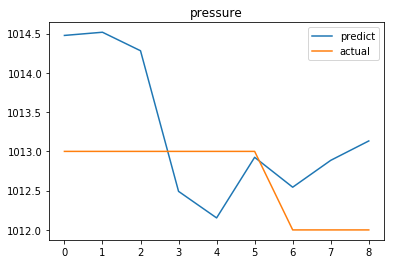

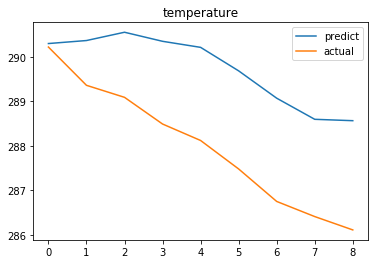

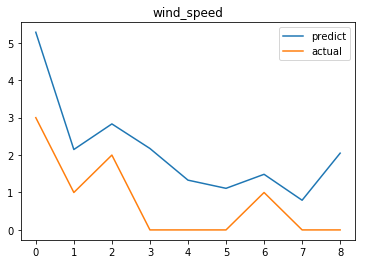

In [49]:
for i, col in enumerate(test.columns):
    plt.plot(range(len(preds_var[i])), preds_var[i], label = "predict")
    plt.plot(range(len(test[col])), test[col], label = "actual")
    plt.legend()
    plt.title(col)
    plt.show()

In [44]:
# find the best maxlags parameter
res = dict()
for i in range(1,20):
    model_fit = model.fit(maxlags = i)
    preds = model_fit.forecast(train.values.tolist(), steps = len(test))
    preds = preds.transpose()
    error = 0
    for j, cl in enumerate(train.columns):
        error = error + np.sqrt(mean_squared_error(preds[j], test[cl]))
    res[i] = error

In [45]:
min(res, key = res.get) # best order for model

14

## Apply VARMAX model 

In [16]:
model = VARMAX(endog = train, order = (11,0))
model_fit = model.fit(maxlags = 11)

C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [17]:
preds_varmax = model_fit.forecast(steps = len(test)) ### steps - how much data forward you want to predict 

preds_varmax = preds_varmax.transpose()

for i, cl in enumerate(train.columns):
    print('mse value for ', cl, ' is : ', mean_squared_error(preds_varmax.loc[cl], test[cl]))
    print('rmse value for ', cl, ' is : ', np.sqrt(mean_squared_error(preds_varmax.loc[cl], test[cl])))
    print('mae value for ', cl, ' is : ', mean_absolute_error(preds_varmax.loc[cl], test[cl]))

mse value for  humidity  is :  91.49173354452512
rmse value for  humidity  is :  9.565131130545211
mae value for  humidity  is :  7.497470932754918
mse value for  pressure  is :  2.553143288027858
rmse value for  pressure  is :  1.5978558408153902
mae value for  pressure  is :  1.47654411536482
mse value for  temperature  is :  6.473489989917939
rmse value for  temperature  is :  2.5443054042150557
mae value for  temperature  is :  2.239026671835657
mse value for  wind_speed  is :  3.201872482750078
rmse value for  wind_speed  is :  1.7893776802983985
mae value for  wind_speed  is :  1.6915881493261422


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


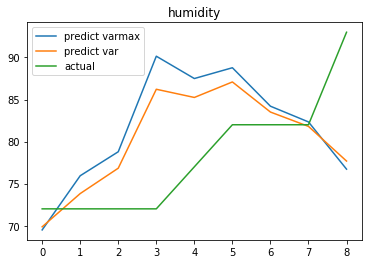

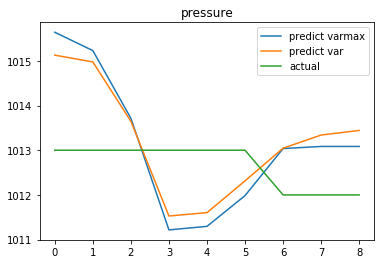

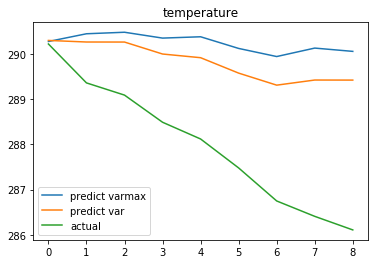

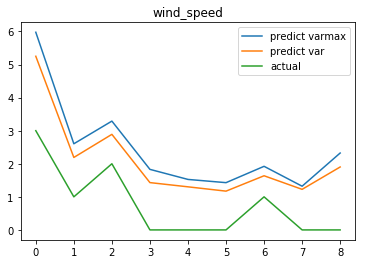

In [18]:
for i, col in enumerate(test.columns):
    plt.plot(range(len(preds_varmax.loc[col])),preds_varmax.loc[col], label = "predict varmax")
    plt.plot(range(len(preds_var[i])), preds_var[i], label = "predict var")
    plt.plot(range(len(test[col])), test[col], label = "actual")
    plt.legend()
    plt.title(col)
    plt.show()

In [243]:
# find the best p , q parameter
res = dict()
for q in range(0,10):
    for p in [7,10,11]:
        model = VARMAX(endog = train, order = (p,q))
        model_fit = model.fit(maxlags = p)
        preds = model_fit.forecast(steps = len(test))
        preds = preds.transpose()
        error = 0
        for j, cl in enumerate(test.columns):
            error = error + np.sqrt(mean_squared_error(preds.loc[cl], test[cl]))
        res[tuple([p,q])] = error
        print("{},{} is done, error = {}".format(p,q, error))

C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Co

7,0 is done, error = 15.611687428938247


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=fr

10,0 is done, error = 14.940941319945608


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=

11,0 is done, error = 14.85872805924382


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

7,1 is done, error = 15.856361232765108


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

10,1 is done, error = 15.047676353736469


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

11,1 is done, error = 14.961114719975523


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

7,2 is done, error = 15.778987819534835


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

10,2 is done, error = 15.35941740098492


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

11,2 is done, error = 15.0793045613662


C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:152: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
C:\Users\Natalia Novosad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarn

7,3 is done, error = 17.190165468388873


KeyboardInterrupt: 

In [244]:
min(res, key = res.get) # best p, q for model

(11, 0)

# Keras LSTM

In [19]:
import keras
from keras import Sequential
from keras.layers import LSTM 
from keras.layers import Dense 

Using TensorFlow backend.


### Transport data for NN

In [50]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    cols, names = list(), list()
    df = pd.DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [j + "(t-{})".format(i) for j in data.columns]
    # forecast sequence (t, t+1, ... t+n) 
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [j + "(t)" for j in data.columns]
        else:
            names += [j + "(t+{})".format(i) for j in data.columns]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True) #any
    return agg

In [51]:
supervised = series_to_supervised(data,1,1)
supervised = supervised.drop(["humidity(t)","pressure(t)", "wind_speed(t)"], axis = 1)
scaler = MinMaxScaler(feature_range=(0, 1))
supervised_scaled = scaler.fit_transform(supervised)

supervised_scaled = pd.DataFrame(supervised_scaled, columns = supervised.columns)

In [52]:
supervised_scaled.head()

humidity(t-1)  pressure(t-1)  temperature(t-1)  wind_speed(t-1)  \
0       0.865169       0.346154          0.294819         0.166667   
1       0.853933       0.346154          0.294589         0.166667   
2       0.842697       0.346154          0.293930         0.166667   
3       0.831461       0.346154          0.293271         0.166667   
4       0.820225       0.346154          0.292612         0.166667   

   temperature(t)  
0        0.294589  
1        0.293930  
2        0.293271  
3        0.292612  
4        0.291953

In [53]:
test = supervised_scaled[split_point_train-1:]
train = supervised_scaled[:split_point_train-1]

train.shape, test.shape 

((399, 5), (9, 5))

In [54]:
features = list(supervised_scaled.columns)
features.remove("temperature(t)")
train_X, train_y = train[features].values, train[["temperature(t)"]].values
test_X, test_y = test[features].values, test[["temperature(t)"]].values

### neeeded for NN
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

### Create NN

In [55]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')

Train on 399 samples, validate on 9 samples
Epoch 1/150
399/399 [==============================] - 1s 2ms/step - loss: 0.3279 - val_loss: 0.1748
Epoch 2/150
399/399 [==============================] - 0s 21us/step - loss: 0.2528 - val_loss: 0.1013
Epoch 3/150
399/399 [==============================] - 0s 20us/step - loss: 0.1986 - val_loss: 0.0639
Epoch 4/150
399/399 [==============================] - 0s 22us/step - loss: 0.1758 - val_loss: 0.0506
Epoch 5/150
399/399 [==============================] - 0s 30us/step - loss: 0.1638 - val_loss: 0.0449
Epoch 6/150
399/399 [==============================] - 0s 20us/step - loss: 0.1565 - val_loss: 0.0425
Epoch 7/150
399/399 [==============================] - 0s 30us/step - loss: 0.1526 - val_loss: 0.0439
Epoch 8/150
399/399 [==============================] - 0s 20us/step - loss: 0.1496 - val_loss: 0.0440
Epoch 9/150
399/399 [==============================] - 0s 20us/step - loss: 0.1472 - val_loss: 0.0435
Epoch 10/150
399/399 [=================

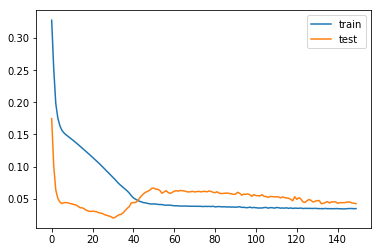

In [56]:
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [57]:
# make a prediction
preds = model.predict(test_X)

test_Y = pd.DataFrame(test, copy = True)
test_Y["temperature(t)"] = preds
test_transformed = scaler.inverse_transform(test_Y)
preds = test_transformed[:,-1]

test_transformed = scaler.inverse_transform(test)
real = test_transformed[:,-1]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(real, preds))
print('Test RMSE for LSTM: ', rmse)
print('rmse value for VARMAX is : ', np.sqrt(mean_squared_error(preds_varmax.loc["temperature"], real)))
print('rmse value for VAR is : ', np.sqrt(mean_squared_error(preds_var[2], real)))

Test RMSE for LSTM:  0.9426917203413263
rmse value for VARMAX is :  2.5443054042150557
rmse value for VAR is :  1.8870058795354505


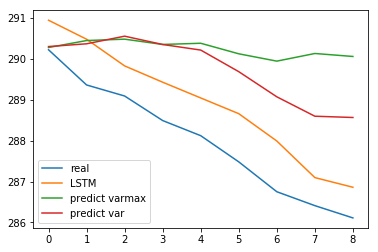

In [58]:
plt.plot(real, label = "real")
plt.plot(preds, label = "LSTM")
plt.plot(range(len(preds_varmax.loc["temperature"])),preds_varmax.loc["temperature"], label = "predict varmax")
plt.plot(range(len(preds_var[2])), preds_var[2], label = "predict var")
plt.legend()